In [28]:
import pandas as pd
from csgo_wp.data_transform import CSGODataset, transform_multichannel
from csgo_wp.model import LR_CNN
import torch

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

def test(model, loader, device):
    model.eval()
    model.to(device)

    targets = []
    outputs = []

    with torch.no_grad():
        for index, (data, target) in enumerate(loader):
            targets.append(target)

            data = data.to(device)
            output = model(data)
            outputs.append(output)

        y_pred = torch.cat(outputs, dim=0).cpu().numpy().astype(float)
        y_true = torch.cat(targets, dim=0).cpu().numpy().astype(float)

        df = pd.DataFrame([y_true, y_pred]).T
        df.columns = ['y_true', 'y_pred']
        df.to_csv('final_model_predictions.csv', index=False)
        
    return df

test_dataset = CSGODataset(transform=transform_multichannel,
                           dataset_split='test',
                           verbose=False,
                           )

test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=64,
                                          shuffle=False,
                                          num_workers=0,
                                          )

device = 'cuda:0'

model = LR_CNN(input_size=(6, 5, 5),
               hidden_sizes=[200, 100, 50],
               activation='LeakyReLU',
               activation_params={},
               dropout=False,
               batch_norm=False,
               cnn_options=((4, 6, 1, 1, 0, 1, 1, 0),
                            (6, 6, 1, 1, 0, 1, 1, 0),
                            (6, 6, 5, 1, 0, 1, 1, 0),),
               )
model.load_state_dict(torch.load('csgo_wp/model-final.pt'))
model.eval();

Reading transformed data...

Done!


In [7]:
df = test(model=model,
          loader=test_loader,
          device=device,
          )

In [8]:
df.head()

,y_true,y_pred
0,0.0,0.452990
1,0.0,0.458283
2,0.0,0.462887
3,0.0,0.473695
4,0.0,0.466792


In [23]:
from sklearn.calibration import calibration_curve
import numpy as np

def expected_calibration_error(y_true, y_pred, bins):
    prob_true, prob_pred = calibration_curve(y_true, y_pred, n_bins=bins, strategy='quantile')
    return np.sum(np.abs(prob_true - prob_pred))

expected_calibration_error(df['y_true'], df['y_pred'], bins=100)

9.132577787689378

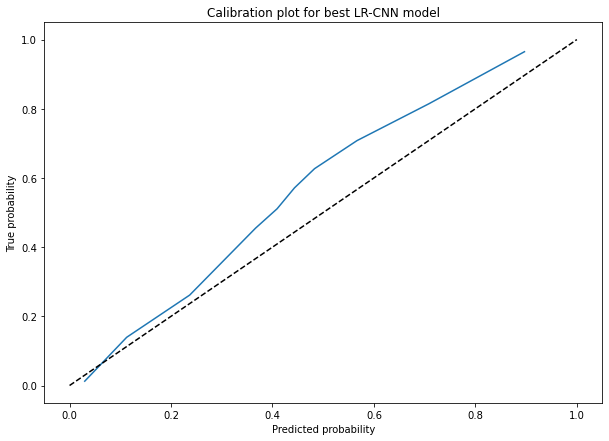

In [22]:
prob_true, prob_pred = calibration_curve(df['y_true'], df['y_pred'], n_bins=10, strategy='quantile')

plt.figure(figsize=(10, 7))
plt.plot(prob_pred, prob_true)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Predicted probability')
plt.ylabel('True probability')
plt.title('Calibration plot for best LR-CNN model');

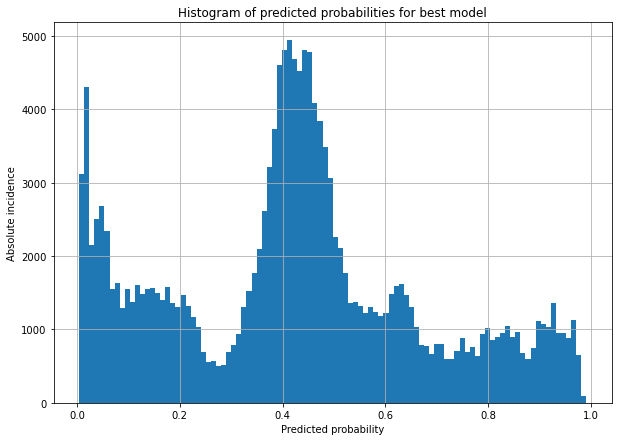

In [26]:
plt.figure(figsize=(10, 7))
df['y_pred'].hist(bins=100)
plt.xlabel('Predicted probability')
plt.ylabel('Absolute incidence')
plt.title('Histogram of predicted probabilities for best model');

In [27]:
df['y_pred'].mean()

0.4253303284886725